In [1]:
import os
import pandas as pd

# 1. Read and concat yearly files
price_list, demand_list = [], []
for year in range(2014, 2026):
    p = pd.read_csv(
        fr'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\PUB_PriceHOEPPredispOR_{year}.csv',
        skiprows=3
    )
    d = pd.read_csv(
        fr'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\PUB_Demand_{year}.csv',
        skiprows=3
    )
    price_list.append(p); demand_list.append(d)

price_df  = pd.concat(price_list,  ignore_index=True)
demand_df = pd.concat(demand_list, ignore_index=True)

# 2. Clean names
price_df.columns  = price_df.columns.str.strip()
demand_df.columns = demand_df.columns.str.strip()

price_df[['Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch']] = \
    price_df[['Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch']].ffill()




for df in (price_df, demand_df):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Step 1: Combine Date and Hour into naive datetime
    naive_ts = df['Date'] + pd.to_timedelta(df['Hour'] - 1, unit='h')

    # Step 2: Localize with correct DST handling
    df['timestamp'] = naive_ts.dt.tz_localize(
        'Canada/Eastern',
        ambiguous=False,               # Handle fall-back DST automatically
        nonexistent='shift_forward'   # Handle spring-forward DST
    ).dt.tz_convert('UTC')



# 4. Drop bad & duplicates
price_df  = price_df.dropna(subset=['timestamp']).drop_duplicates(subset=['timestamp'])
demand_df = demand_df.dropna(subset=['timestamp']).drop_duplicates(subset=['timestamp'])

# 5. Merge price + demand on timestamp
combined_df = pd.merge(
    price_df, demand_df,
    on='timestamp', how='inner',
    suffixes=('_price','_demand')
)
combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)

# 6. Cleanup
combined_df = combined_df.drop(
    columns=[
        'Date_price','Hour_price',
        'Date_demand','Hour_demand',
        'OR 10 Min Sync','OR 10 Min non-sync','OR 30 Min', 'Market Demand'
    ],
    errors='ignore'
)
combined_df = combined_df.set_index('timestamp')


print(f"\nFinal shape: {combined_df.shape}")
print(combined_df.isna().sum())
print("Range:", combined_df.index.min(), "→", combined_df.index.max())


Final shape: (99300, 5)
HOEP                  0
Hour 1 Predispatch    0
Hour 2 Predispatch    0
Hour 3 Predispatch    0
Ontario Demand        0
dtype: int64
Range: 2014-01-01 05:00:00+00:00 → 2025-05-01 03:00:00+00:00


In [2]:
import os
import pandas as pd

# 1. Config
root = r'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\weather'
cities = ['toronto','kitchener','london','ottawa']
col_map = {
    "Temp (°C)":    "temp",
    "Rel Hum (%)":  "humidity",
    "Wind Spd (km/h)": "wind_speed",
}

city_dfs = []
for city in cities:
    p = os.path.join(root, city)
    dfs = []
    for fname in sorted(os.listdir(p)):
        df = pd.read_csv(os.path.join(p, fname))
        df.columns = df.columns.str.strip().str.replace('"','')

        naive_ts = pd.to_datetime(df['Date/Time (LST)'], errors='coerce')

        df = df[list(col_map)].rename(columns=col_map)


        df['timestamp'] = naive_ts.dt.tz_localize('Canada/Eastern', ambiguous=False, nonexistent='shift_forward').dt.tz_convert('UTC')
        dfs.append(df)
    
   
    city_df = pd.concat(dfs, ignore_index=True)
    city_df  = city_df.drop_duplicates(subset=['timestamp']) 
    city_df = city_df.set_index('timestamp').sort_index()
    # Now forward fill
    city_df = city_df.ffill()
    city_df = city_df.add_suffix(f"_{city}")
    city_dfs.append(city_df)

# inner join across all cities (keeps only timestamps present in every city)
from functools import reduce
weather_df = reduce(lambda L, R: L.join(R, how='inner'), city_dfs)
weather_df = weather_df.sort_index()

print("Shape:", weather_df.shape)
print("Range:", weather_df.index.min(), "→", weather_df.index.max())



Shape: (99300, 12)
Range: 2014-01-01 05:00:00+00:00 → 2025-05-01 03:00:00+00:00


In [3]:
# Both have 'timestamp' index in UTC now, accounts for daylight savings
final_df = combined_df.join(weather_df, how='inner')

print("\nMerged shape:", final_df.shape)
print("Merged range:", final_df.index.min(), final_df.index.max())
print(final_df.isna().sum())

print(final_df.head())


Merged shape: (99300, 17)
Merged range: 2014-01-01 05:00:00+00:00 2025-05-01 03:00:00+00:00
HOEP                    0
Hour 1 Predispatch      0
Hour 2 Predispatch      0
Hour 3 Predispatch      0
Ontario Demand          0
temp_toronto            0
humidity_toronto        0
wind_speed_toronto      0
temp_kitchener          0
humidity_kitchener      0
wind_speed_kitchener    0
temp_london             0
humidity_london         0
wind_speed_london       0
temp_ottawa             0
humidity_ottawa         0
wind_speed_ottawa       0
dtype: int64
                            HOEP Hour 1 Predispatch Hour 2 Predispatch  \
timestamp                                                                
2014-01-01 05:00:00+00:00  23.04              32.44                 32   
2014-01-01 06:00:00+00:00  36.64              32.44              32.44   
2014-01-01 07:00:00+00:00  45.85              32.59              32.59   
2014-01-01 08:00:00+00:00  30.88              32.44              32.44   
2014-01-

In [21]:
import numpy as np
import pandas as pd
import holidays

# ---------------- CONFIG ----------------
lags = [2, 3, 24, 48, 168]
roll_windows = [3, 23, 167]
ontario_holidays = holidays.Canada(prov='ON')

# ---------------- LOAD + HOURLY ALIGNMENT ----------------
df = final_df.copy()
df = df.reset_index()
# Convert HOEP from string to numeric
df['HOEP'] = pd.to_numeric(df['HOEP'].astype(str).str.replace(',', ''), errors='coerce')
df['Hour 1 Predispatch'] = pd.to_numeric(df['Hour 1 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df['Hour 2 Predispatch'] = pd.to_numeric(df['Hour 2 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df['Hour 3 Predispatch'] = pd.to_numeric(df['Hour 3 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ---------------- TIME FEATURES ----------------
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['quarter'] = df['timestamp'].dt.quarter

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['is_holiday'] = df['timestamp'].dt.date.isin(ontario_holidays).astype(int)
df['is_business_day'] = ((df['day_of_week'] < 5) & (~df['is_holiday'])).astype(int)
df['hour_of_week'] = df['day_of_week'] * 24 + df['hour']

# ---------------- LAG FEATURES ----------------
for k in lags:
    df[f'demand_lag_{k}'] = df['Ontario Demand'].shift(k)
    df[f'HOEP_lag_{k}'] = df['HOEP'].shift(k)

    
    # Add lags for each city
    df[f'temp_toronto_lag_{k}'] = df['temp_toronto'].shift(k)
    df[f'humidity_toronto_lag_{k}'] = df['humidity_toronto'].shift(k)
    df[f'wind_speed_toronto_lag_{k}'] = df['wind_speed_toronto'].shift(k)
    
    df[f'temp_kitchener_lag_{k}'] = df['temp_kitchener'].shift(k)
    df[f'humidity_kitchener_lag_{k}'] = df['humidity_kitchener'].shift(k)
    df[f'wind_speed_kitchener_lag_{k}'] = df['wind_speed_kitchener'].shift(k)
    
    df[f'temp_london_lag_{k}'] = df['temp_london'].shift(k)
    df[f'humidity_london_lag_{k}'] = df['humidity_london'].shift(k)
    df[f'wind_speed_london_lag_{k}'] = df['wind_speed_london'].shift(k)
    
    df[f'temp_ottawa_lag_{k}'] = df['temp_ottawa'].shift(k)
    df[f'humidity_ottawa_lag_{k}'] = df['humidity_ottawa'].shift(k)
    df[f'wind_speed_ottawa_lag_{k}'] = df['wind_speed_ottawa'].shift(k)


for win in roll_windows:
    df[f'demand_ma_{win}'] = df['demand_lag_2'].rolling(win).mean()
    df[f'HOEP_ma_{win}'] = df['HOEP_lag_2'].rolling(win).mean()
    
    df[f'temp_toronto_ma_{win}'] = df['temp_toronto_lag_2'].rolling(win).mean()
    df[f'humidity_toronto_ma_{win}'] = df['humidity_toronto_lag_2'].rolling(win).mean()
    df[f'wind_speed_toronto_ma_{win}'] = df['wind_speed_toronto_lag_2'].rolling(win).mean()

df['HOEP_volatility_24h'] = df['HOEP_lag_2'].rolling(23).std()
df['HOEP_range_24h'] = df['HOEP_lag_2'].rolling(23).max() - df['HOEP_lag_2'].rolling(23).min()

# Temperature changes for each city
df['temp_toronto_change_24h'] = df['temp_toronto_lag_2'] - df['temp_toronto_lag_24']
df['temp_kitchener_change_24h'] = df['temp_kitchener_lag_2'] - df['temp_kitchener_lag_24']
df['temp_london_change_24h'] = df['temp_london_lag_2'] - df['temp_london_lag_24']
df['temp_ottawa_change_24h'] = df['temp_ottawa_lag_2'] - df['temp_ottawa_lag_24']


df['temp_toronto_squared_lag_2'] = df['temp_toronto_lag_2'] ** 2
df['temp_ottawa_squared_lag_2'] = df['temp_ottawa_lag_2'] ** 2
df['temp_kitchener_squared_lag_2'] = df['temp_kitchener_lag_2'] ** 2
df['temp_london_squared_lag_2'] = df['temp_london_lag_2'] ** 2

# ---------------- INTERACTIONS ----------------
df['demand_temp_toronto_interaction'] = df['demand_lag_2'] * df['temp_toronto_lag_2']
df['hour_weekend_interaction'] = df['hour'] * df['is_weekend']
df['temp_humidity_toronto_interaction'] = df['temp_toronto_lag_2'] * df['humidity_toronto_lag_2']
df['demand_HOEP_ratio_lag_2'] = df['demand_lag_2'] / (df['HOEP_lag_2'] + 1e-6)


df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df.set_index('timestamp').sort_index()
df = df.dropna()

# ---------------- REPORT ----------------
temporal_features = ['hour', 'day_of_week', 'month', 'year', 'quarter',
                    'hour_sin', 'hour_cos', 'is_weekend', 'month_sin', 'month_cos', 
                    'week_of_year_sin', 'week_of_year_cos', 'day_of_year', 'doy_sin', 'doy_cos',
                    'is_holiday', 'is_business_day', 'hour_of_week']
lag_features = [col for col in df.columns if '_lag_' in col]
rolling_features = [col for col in df.columns if '_ma_' in col or 'volatility' in col or 'range' in col]
interaction_features = [col for col in df.columns if 'interaction' in col or 'ratio' in col]
weather_derived = [col for col in df.columns if 'change_24h' in col or 'squared_lag_2' in col]

df = df.drop(columns=[
        'Ontario Demand',   'temp_toronto', 'temp_london', 'temp_ottawa', 'temp_kitchener',
    'wind_speed_toronto', 'wind_speed_london', 'wind_speed_ottawa', 'wind_speed_kitchener',
    'humidity_toronto', 'humidity_london', 'humidity_ottawa', 'humidity_kitchener'
    ])
df = df.dropna()
print(f"Final shape: {df.shape}")
print(df.columns.tolist())

features = temporal_features + lag_features + rolling_features + interaction_features 




C:\Users\owner\AppData\Local\Temp\ipykernel_16784\1239775888.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'humidity_toronto_ma_{win}'] = df['humidity_toronto_lag_2'].rolling(win).mean()
C:\Users\owner\AppData\Local\Temp\ipykernel_16784\1239775888.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'wind_speed_toronto_ma_{win}'] = df['wind_speed_toronto_lag_2'].rolling(win).mean()
C:\Users\owner\AppData\Local\Temp\ipykernel_16784\1239775888.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usual

Final shape: (99132, 122)
['HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'hour', 'day_of_week', 'month', 'year', 'quarter', 'hour_sin', 'hour_cos', 'is_weekend', 'month_sin', 'month_cos', 'week_of_year', 'week_of_year_sin', 'week_of_year_cos', 'day_of_year', 'doy_sin', 'doy_cos', 'is_holiday', 'is_business_day', 'hour_of_week', 'demand_lag_2', 'HOEP_lag_2', 'temp_toronto_lag_2', 'humidity_toronto_lag_2', 'wind_speed_toronto_lag_2', 'temp_kitchener_lag_2', 'humidity_kitchener_lag_2', 'wind_speed_kitchener_lag_2', 'temp_london_lag_2', 'humidity_london_lag_2', 'wind_speed_london_lag_2', 'temp_ottawa_lag_2', 'humidity_ottawa_lag_2', 'wind_speed_ottawa_lag_2', 'demand_lag_3', 'HOEP_lag_3', 'temp_toronto_lag_3', 'humidity_toronto_lag_3', 'wind_speed_toronto_lag_3', 'temp_kitchener_lag_3', 'humidity_kitchener_lag_3', 'wind_speed_kitchener_lag_3', 'temp_london_lag_3', 'humidity_london_lag_3', 'wind_speed_london_lag_3', 'temp_ottawa_lag_3', 'humidity_ottawa_lag_3', '

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Define quantile loss function
def quantile_loss(q):
    """Custom loss function for quantile regression"""
    def loss(y_true, y_pred):
        error = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))
    return loss

# Define multiple quantiles to predict
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th (median), 90th percentiles

# Method 1: Single model predicting multiple quantiles
def create_multi_quantile_model(input_shape, quantiles):
    """Create model that predicts multiple quantiles simultaneously"""
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(32),
        LeakyReLU(alpha=0.01),
        Dense(len(quantiles), activation='linear')  # One output per quantile
    ])
    
    # Custom combined loss for multiple quantiles
    def combined_quantile_loss(y_true, y_pred):
        total_loss = 0
        for i, q in enumerate(quantiles):
            q_pred = y_pred[:, i:i+1]
            error = y_true - q_pred
            total_loss += tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))
        return total_loss
    
    model.compile(optimizer=Adam(0.001), loss=combined_quantile_loss)
    return model

# Method 2: Separate models for each quantile 
def create_single_quantile_model(input_shape, quantile):
    """Create model for single quantile prediction"""
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(32),
        LeakyReLU(alpha=0.01),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(0.001), loss=quantile_loss(quantile))
    return model

# Training function for quantile regression
def train_quantile_models(X_train, y_train, X_test, y_test, method='separate'):
    """Train quantile regression models"""
    
    if method == 'combined':
        # Method 1: Single model for all quantiles
        model = create_multi_quantile_model(X_train.shape[1], quantiles)
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=1
        )
        
        # Predict all quantiles
        predictions = model.predict(X_test, verbose=0)
        
        # Separate predictions by quantile
        quantile_predictions = {}
        for i, q in enumerate(quantiles):
            quantile_predictions[f'q_{int(q*100)}'] = predictions[:, i]
            
    else:
        # Method 2: Separate models for each quantile (recommended)
        quantile_models = {}
        quantile_predictions = {}
        
        for q in quantiles:
            print(f"Training quantile {q} model...")
            
            model = create_single_quantile_model(X_train.shape[1], q)
            
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            model.fit(
                X_train, y_train,
                validation_split=0.1,
                epochs=100,
                batch_size=32,
                callbacks=[early_stop],
                verbose=0
            )
            
            # Store model and predictions
            quantile_models[f'q_{int(q*100)}'] = model
            quantile_predictions[f'q_{int(q*100)}'] = model.predict(X_test, verbose=0).flatten()
    
    return quantile_predictions

# Evaluation metrics for quantile regression
def evaluate_quantile_predictions(y_true, quantile_predictions):
    """Evaluate quantile regression performance"""
    results = {}
    
    for q_name, q_pred in quantile_predictions.items():
        q_value = float(q_name.split('_')[1]) / 100
        
        # Pinball loss (quantile loss)
        error = y_true - q_pred
        pinball_loss = np.mean(np.maximum(q_value * error, (q_value - 1) * error))
        
        # Coverage (what % of actual values fall below this quantile)
        coverage = np.mean(y_true <= q_pred)
        
        # RMSE for this quantile
        rmse = np.sqrt(np.mean((y_true - q_pred)**2))
        
        results[q_name] = {
            'pinball_loss': pinball_loss,
            'coverage': coverage,
            'expected_coverage': q_value,
            'rmse': rmse
        }
    
    return results

# Prediction interval metrics
def calculate_prediction_intervals(quantile_predictions, confidence_levels=[0.8]):
    """Calculate prediction intervals from quantile predictions"""
    intervals = {}
    
    for conf_level in confidence_levels:
        alpha = 1 - conf_level
        lower_q = f"q_{int((alpha/2)*100)}"
        upper_q = f"q_{int((1-alpha/2)*100)}"
        
        if lower_q in quantile_predictions and upper_q in quantile_predictions:
            intervals[f'{int(conf_level*100)}%'] = {
                'lower': quantile_predictions[lower_q],
                'upper': quantile_predictions[upper_q],
                'width': quantile_predictions[upper_q] - quantile_predictions[lower_q]
            }
    
    return intervals

# Visualization function
def plot_quantile_predictions(y_true, quantile_predictions, start_idx=0, end_idx=200):
    """Plot quantile predictions with uncertainty bands"""
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    x = range(start_idx, min(end_idx, len(y_true)))
    plt.plot(x, y_true[start_idx:end_idx], 'k-', label='Actual HOEP', linewidth=2)
    
    # Plot median prediction
    if 'q_50' in quantile_predictions:
        plt.plot(x, quantile_predictions['q_50'][start_idx:end_idx], 'r--', 
                label='Median Prediction', linewidth=2)
    
    # Plot uncertainty bands
    if 'q_10' in quantile_predictions and 'q_90' in quantile_predictions:
        plt.fill_between(x, 
                        quantile_predictions['q_10'][start_idx:end_idx],
                        quantile_predictions['q_90'][start_idx:end_idx],
                        alpha=0.3, color='blue', label='80% Prediction Interval')
    
    plt.xlabel('Time (hours)')
    plt.ylabel('HOEP (CAD/MWh)')
    plt.title('Quantile Regression Predictions with Uncertainty')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    

In [32]:
# 3-way split for proper validation
train_cutoff = pd.Timestamp("2023-01-01 00:00:00", tz="UTC")
val_cutoff = pd.Timestamp("2024-01-01 00:00:00", tz="UTC")
final_cutoff = pd.Timestamp("2025-01-01 00:00:00", tz='UTC')

df_train = df[df.index < train_cutoff]          # 2014-2022
df_val = df[(df.index >= train_cutoff) & (df.index < val_cutoff)]  # 2023
df_test = df[(df.index >= val_cutoff ) & (df.index < final_cutoff)]             # 2024

target = "HOEP"

X_train_raw = df_train[features].apply(pd.to_numeric, errors="coerce")
y_train = pd.to_numeric(df_train[target], errors="coerce")

X_val_raw = df_val[features].apply(pd.to_numeric, errors="coerce")
y_val = pd.to_numeric(df_val[target], errors="coerce")

X_test_raw = df_test[features].apply(pd.to_numeric, errors="coerce")
y_test = pd.to_numeric(df_test[target], errors="coerce")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predictions from IESO Hour 1 Predispatch
y_predispatch = pd.to_numeric(df_test["Hour 1 Predispatch"], errors="coerce")

# Metrics (assuming no NaNs)
rmse_predispatch = np.sqrt(mean_squared_error(y_test, y_predispatch))
mae_predispatch  = mean_absolute_error(y_test, y_predispatch)
# Hour 2
rmse_2 = np.sqrt(mean_squared_error(y_test, df_test["Hour 2 Predispatch"]))
mae_2  = mean_absolute_error(y_test, df_test["Hour 2 Predispatch"])

# Hour 3
rmse_3 = np.sqrt(mean_squared_error(y_test, df_test["Hour 3 Predispatch"]))
mae_3  = mean_absolute_error(y_test, df_test["Hour 3 Predispatch"])


print(f"Hour 1 Predispatch RMSE: {rmse_predispatch:.2f} CAD/MWh")
print(f"Hour 1 Predispatch MAE : {mae_predispatch:.2f} CAD/MWh")
print(f"Hour 2 Predispatch RMSE: {rmse_2:.2f} CAD/MWh")
print(f"Hour 2 Predispatch MAE : {mae_2:.2f} CAD/MWh")
print(f"Hour 3 Predispatch RMSE: {rmse_3:.2f} CAD/MWh")
print(f"Hour 3 Predispatch MAE : {mae_3:.2f} CAD/MWh")

Hour 1 Predispatch RMSE: 32.14 CAD/MWh
Hour 1 Predispatch MAE : 11.68 CAD/MWh
Hour 2 Predispatch RMSE: 29.67 CAD/MWh
Hour 2 Predispatch MAE : 11.44 CAD/MWh
Hour 3 Predispatch RMSE: 28.38 CAD/MWh
Hour 3 Predispatch MAE : 10.54 CAD/MWh


In [23]:

    
print("Training quantile regression models...")
quantile_predictions = train_quantile_models(X_train, y_train, X_test, y_test, method='separate')
    
print("\nEvaluating quantile predictions...")
results = evaluate_quantile_predictions(y_test, quantile_predictions)
    
print("\n=== Quantile Regression Results ===")
for q_name, metrics in results.items():
    print(f"\nQuantile {q_name}:")
    print(f"  RMSE: {metrics['rmse']:.2f}")
    print(f"  Pinball Loss: {metrics['pinball_loss']:.2f}")
    print(f"  Coverage: {metrics['coverage']:.3f} (expected: {metrics['expected_coverage']:.3f})")
    
# Calculate prediction intervals
intervals = calculate_prediction_intervals(quantile_predictions)
    
print("\n=== Prediction Intervals ===")
for interval_name, interval_data in intervals.items():
    avg_width = np.mean(interval_data['width'])
    print(f"{interval_name} interval average width: {avg_width:.2f} CAD/MWh")

    
print(f"Median quantile RMSE: {results['q_50']['rmse']:.2f}")
   


Training quantile regression models...
Training quantile 0.1 model...


c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training quantile 0.5 model...


c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training quantile 0.9 model...


c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Evaluating quantile predictions...

=== Quantile Regression Results ===

Quantile q_10:
  RMSE: 37.99
  Pinball Loss: 2.02
  Coverage: 0.088 (expected: 0.100)

Quantile q_50:
  RMSE: 33.94
  Pinball Loss: 5.15
  Coverage: 0.394 (expected: 0.500)

Quantile q_90:
  RMSE: 38.28
  Pinball Loss: 4.53
  Coverage: 0.894 (expected: 0.900)

=== Prediction Intervals ===
Median quantile RMSE: 33.94


Hyperparameter Tuning Results:
n_hidden=500: Validation RMSE = 16.88, Train Time = 7.282s
n_hidden=750: Validation RMSE = 16.81, Train Time = 16.097s
n_hidden=1000: Validation RMSE = 16.94, Train Time = 24.457s
n_hidden=1250: Validation RMSE = 16.88, Train Time = 34.115s
----------------------------------------
Best n_hidden: 750
Best validation RMSE: 16.81
Best model train time: 16.097s

Final Test Results:
Test RMSE: 24.17
Test MAE : 9.09
Test R²  : 0.201


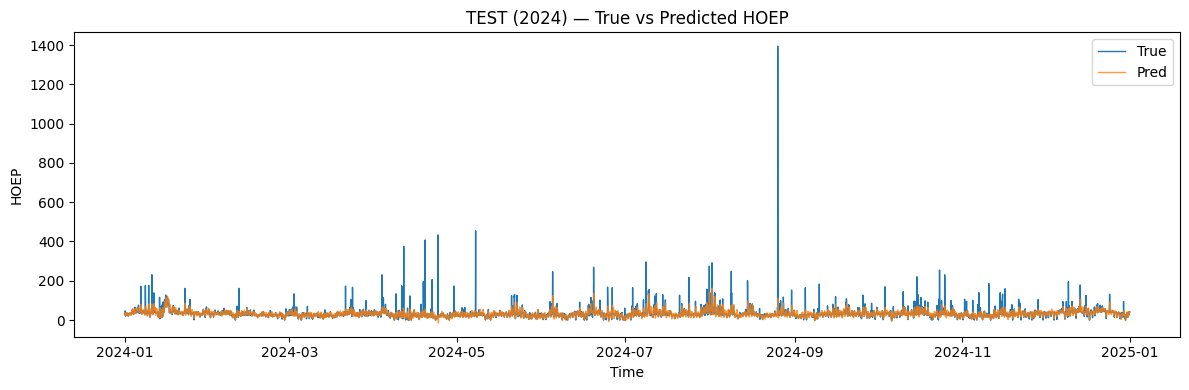

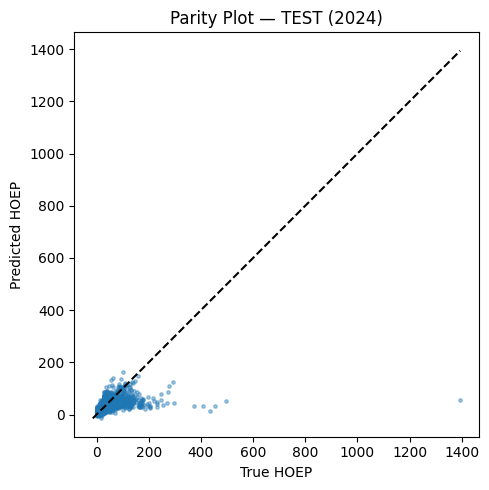

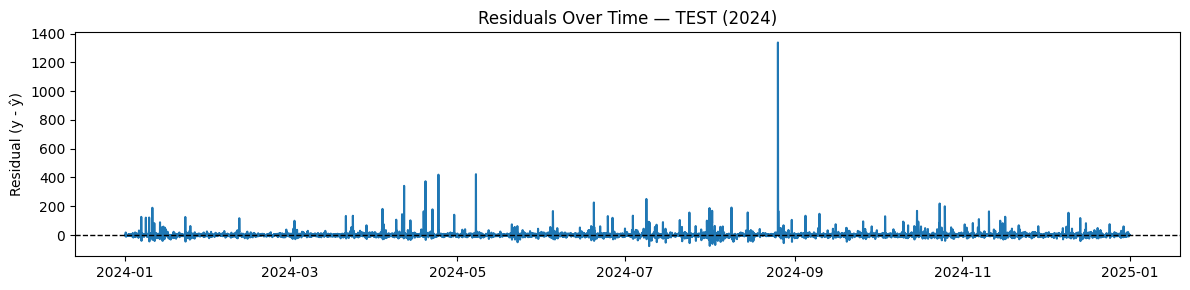

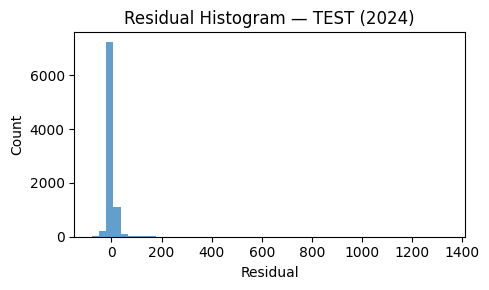

In [44]:
# ---- ELM Training and Testing ----
import time
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd  
from sklearn.feature_selection import SelectKBest, f_regression

np.random.seed(42)
selector = SelectKBest(score_func=f_regression, k=20)
X_train_sel = selector.fit_transform(X_train, y_train)
X_val_sel   = selector.transform(X_val)
X_test_sel  = selector.transform(X_test)

best_rmse = float('inf')
best_n_hidden = None
best_train_time = None

print("Hyperparameter Tuning Results:")

for n_hidden in [500, 750, 1000, 1250]:
    start_time = time.time()
    
    W_in = np.random.randn(X_train_sel.shape[1], n_hidden)
    H_train = np.maximum(0, X_train_sel @ W_in)
    H_val = np.maximum(0, X_val_sel @ W_in)
    W_out = np.linalg.pinv(H_train) @ y_train
    
    train_time = time.time() - start_time
    
    y_val_pred = H_val @ W_out
    val_rmse = np.sqrt(np.mean((y_val - y_val_pred)**2))
    
    print(f"n_hidden={n_hidden}: Validation RMSE = {val_rmse:.2f}, Train Time = {train_time:.3f}s")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_n_hidden = n_hidden
        best_train_time = train_time

print("-" * 40)
print(f"Best n_hidden: {best_n_hidden}")
print(f"Best validation RMSE: {best_rmse:.2f}")
print(f"Best model train time: {best_train_time:.3f}s")

# ---- Final Model on Test ----
print("\nFinal Test Results:")
np.random.seed(42)
W_in = np.random.randn(X_train_sel.shape[1], best_n_hidden)
H_train = np.maximum(0, X_train_sel @ W_in)
H_test = np.maximum(0, X_test_sel @ W_in)
W_out = np.linalg.pinv(H_train) @ y_train

y_test_pred = H_test @ W_out

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
r2   = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE : {mae:.2f}")
print(f"Test R²  : {r2:.3f}")

# ---- Save Model ----
joblib.dump({
    "W_in": W_in,
    "W_out": W_out,
    "n_hidden": best_n_hidden,
    "scaler": scaler,
    "selector": selector
}, "elm_model.pkl")

# ---- Plotting ----
y_test_s = pd.Series(y_test, index=df_test.index)
y_pred_s = pd.Series(y_test_pred, index=df_test.index)

plt.figure(figsize=(12,4))
plt.plot(y_test_s.index, y_test_s, label="True", linewidth=1)
plt.plot(y_pred_s.index, y_pred_s, label="Pred", alpha=0.8, linewidth=1)
plt.title("TEST (2024) — True vs Predicted HOEP")
plt.xlabel("Time"); plt.ylabel("HOEP"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test_s, y_pred_s, s=6, alpha=0.4)
lims = [min(y_test_s.min(), y_pred_s.min()), max(y_test_s.max(), y_pred_s.max())]
plt.plot(lims, lims, 'k--')
plt.xlabel("True HOEP"); plt.ylabel("Predicted HOEP")
plt.title("Parity Plot — TEST (2024)")
plt.tight_layout(); plt.show()

resid = y_test_s - y_pred_s
plt.figure(figsize=(12,3))
plt.plot(resid.index, resid)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title("Residuals Over Time — TEST (2024)")
plt.ylabel("Residual (y - ŷ)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3))
plt.hist(resid, bins=50, alpha=0.7)
plt.title("Residual Histogram — TEST (2024)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

